<a href="https://colab.research.google.com/github/chrishuskey/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/Assignment_DS_212_Regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [✓] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [✓] Engineer at least two new features. (See below for explanation & ideas.)
- [✓] Fit a linear regression model with at least two features.
- [✓] Get the model's coefficients and intercept.
- [✓] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [✓] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [✓] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [✓] Add your own stretch goal(s) !:  Experiment with better feature selection using the model coefficients (LinReg coeffs + SelectFromModel), Recursive Feature Elimination, etc.

In [0]:
# Import libraries:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
# Read New York City apartment rental listing data
rent_data = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert rent_data.shape == (49352, 34)

In [0]:
# Remove the most extreme 0.1% of prices,
# the most extreme 0.1% of latitudes, &
# the most extreme 0.1% of longitudes:
rent_data = rent_data[(rent_data['price'] >= rent_data['price'].quantile(0.001)) & 
        (rent_data['price'] <= rent_data['price'].quantile(0.999)) & 
        (rent_data['latitude'] >= rent_data['latitude'].quantile(0.001)) & 
        (rent_data['latitude'] <= rent_data['latitude'].quantile(0.999)) &
        (rent_data['longitude'] >= rent_data['longitude'].quantile(0.001)) & 
        (rent_data['longitude'] <= rent_data['longitude'].quantile(0.999))]

In [0]:
# Change to the right data types:
rent_data['created'] = pd.to_datetime(rent_data['created'], infer_datetime_format=True)  # Note: Using infer_datetime_format can supposedly be up to 5-10x faster w.r.t. processing time

In [0]:
# Split into training and test data:
# Training data: listings from April and May 2016
# Test data: listings from June 2016
working_data = rent_data[(rent_data['created'].dt.month <= 5)]
test = rent_data[rent_data['created'].dt.month == 6]

# Split working_data into train and val sets:
train, val = train_test_split(working_data, train_size=0.75, shuffle=True, random_state=42)



# Check to make sure the resulting datasets have the right numbers of 
# observations (and that we got all of them) and features:
assert (working_data.shape[0] + test.shape[0] == rent_data.shape[0]) & (
    working_data.shape[1] == test.shape[1] == rent_data.shape[1])

assert (train.shape[0] + val.shape[0] + test.shape[0] == rent_data.shape[0]) & (
    train.shape[1] == val.shape[1] == test.shape[1] == rent_data.shape[1])

In [0]:
# Function that implements all data prep. on input train/val/test datasets 
# in the same way:
def data_prep(dataframe):
  # Make copy to work with:
  df = dataframe.copy()

  # Add new feature:  Total # of bedrooms and bathrooms:
  df['bedrooms+bathrooms'] = df['bedrooms'] + df['bathrooms']

  # Add new feature:  Perks by price tiers:
  # The current features for amenities are all binary 0/1 
  # variables better suited to classification approaches.  But since we're 
  # required to use linear regression to predict price here instead, 
  # one way to improve price-predicting power would be to group perks by 
  # corresponding price level (based on rarity in the data set, with some 
  # manual adjustments based on intuition / "domain knowledge"):
  # (1) Level 1 perks: slight price-boosters
  # (2) Level 2 perks: higher end perks indicative of higher-rent apartments
  # (3) Level 3 perks: luxury perks indicative of very expensive apartments
  df['L1_price_boost_perks'] = df['elevator'] + (df['cats_allowed'] & df['dogs_allowed']) + df['laundry_in_building']
  df['L2_high_end_perks'] = df['hardwood_floors'] + df['doorman'] + df['dishwasher'] + df['fitness_center'] + df['pre-war'] + df['roof_deck'] + df['high_speed_internet']
  df['L3_luxury_perks'] = df['swimming_pool'] + df['laundry_in_unit'] + df['terrace'] + df['balcony'] + df['new_construction'] + df['loft']

  # Pull info from datetime, bc we can't feed type datetime into sklearn models:
  df['created_year'] = df['created'].dt.year
  df['created_month'] = df['created'].dt.month

  # Convert "interest_level" to ordinal (1/2/3 numerical representation), 
  # so we can work with this feature more easily:
  df['interest_level'] = df['interest_level'].replace({'low': 1, 'medium': 2, 'high': 3})

  # ------------------------------------------------------------------------------

  # [?? TO DO all below just for practice with aspects of Pandas/Python -- these 
  # are all things I'm not 100% sure how to do, but should know how to do! ??]]

  # [?? What to do about the warnings below?  I'm getting the same warning x2 
  # when I use .loc instead to do the same as the above... ??]

  # [?? Luxury:
  # contains "luxury" in description (but this would be a 0/1 binary feature... 
  # only useful for classification, or can we use with regression too?) ??]

  # [?? For the perks feature above, what is a better way to do this?  How would 
  # a top tier data scientist frame this problem, if constrained to only using a 
  # linear regression model and this starter dataset ??]

  # [?? Column selection based on conditions/criteria:  Sort perks into medium/price-boost, high-end/premium perks and luxury 
  # perks automatically, by sorting the column names based on conditions: 
  # median as 1 or 0, 75% percentile as 1 or 0, 90% quantile as 1 or 0.  
  # Not sure how to work with columns this way, only rows!!... --> need to learn ??]

  # df_a = train.copy()
  # a = df_a.median() == 0
  # a = pd.DataFrame(a)
  # a = a.reset_index()
  # a.columns = ['index', 'criterion']

  # b = a[a['criterion'] == True]
  # b

  # # for i in a:
  # #   if a.loc[i, criterion] == True:
  # #     print(a[i].index)

  # # # pd.DataFrame(data=train, column=list)
  
  return df

In [0]:
# Implement data prep on each of train, val, test:
train = data_prep(train)
val = data_prep(val)
test = data_prep(test)

In [0]:
# # [?? To Do:  Improve new feature #2 by first weighting the following features 
# # by rarity and likely level of demand, rather than just adding up all of the 
# # 1's (has/doesn't have x amenity) ??]

# # Categorize as:  Price premium features:
# # Median and up:
# 'elevator', 
# ('cats_allowed' & 'dogs_allowed', )
# ('laundry_in_building' or 'laundry_in_unit')

# # Categorize as:  High-end perks:
# # 75% and up:
# 'hardwood_floors', 
# 'doorman', 
# 'dishwasher', 
# 'fitness_center', 
# 'roof_deck'
# 'high_speed_internet', 
# 'pre-war', 

# # Categorize as:  Luxury perks:
# # Higher %s only (not even 75% has):
# 'swimming_pool'
# 'laundry_in_unit',  # means it's more likely to be a larger apt. --> higher price
# 'balcony', 
# 'terrace', 
# 'new_construction', 
# 'loft',

# **Baselines:**

In [380]:
# DummyRegressor (mean) model to start with:
mean_price = train[target].mean()

# Performance of our dummy regression model:
print('Performance: Baseline #1, Dummy Regression (Mean) Model:\n')

# Performance on Training Set:
print('On Training Set:')
y_true_train = y_train
y_pred_train = [mean_price] * len(y_train)

print(f'MAE: {mean_absolute_error(y_true_train, y_pred_train):.2f}')
mse_train = mean_squared_error(y_true_train, y_pred_train)
print(f'MSE: {mse_train:.2f}')
print(f'RMSE: {sqrt(mse_train):.2f}')
print(f'R^2 score: {r2_score(y_true_train, y_pred_train):.2f}\n')

# Performance on Validation Set:
print('On Validation Set:')
y_true_val = y_val
y_pred_val = [mean_price] * len(y_val)

print(f'MAE: {mean_absolute_error(y_true_val, y_pred_val):.2f}')
mse_val = mean_squared_error(y_true_val, y_pred_val)
print(f'MSE: {mse_val:.2f}')
print(f'RMSE: {sqrt(mse_val):.2f}')
print(f'R^2 score: {r2_score(y_true_val, y_pred_val):.2f}\n')

Performance: Baseline #1, Dummy Regression (Mean) Model:

On Training Set:
MAE: 1280.13
MSE: 4290590.36
RMSE: 2071.37
R^2 score: 0.00

On Validation Set:
MAE: 1299.49
MSE: 4552541.37
RMSE: 2133.67
R^2 score: -0.00



In [381]:
# Multiple Linear Regression Model for the above NYC apartment rent data:

# Import model class:
from sklearn.linear_model import LinearRegression

# Initiate model:
model = LinearRegression()

# Features matrix and target vector:
features = ['bedrooms+bathrooms', 'interest_level', 'L1_price_boost_perks', 'L2_high_end_perks', 'L3_luxury_perks']
target = 'price'

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

# Fit the model to our training data:
model.fit(X_train, y_train)

# Model Performance:
print('Model Performance: Model #1, LinearRegression\n')

# Error on training set:
print('On Training Set:')
y_true_train = y_train
y_pred_train = model.predict(X_train)

print(f'MAE: {mean_absolute_error(y_true_train, y_pred_train):.1f}')
mse_train = mean_squared_error(y_true_train, y_pred_train)
print(f'MSE: {mse_train:.1f}')
print(f'RMSE: {sqrt(mse_train):.1f}')
print(f'R^2 score: {r2_score(y_true_train, y_pred_train):.2f}\n')

# Error on new data: our test set:
print('On Validation Set:')
y_true_val = y_val
y_pred_val = model.predict(X_val)

print(f'MAE: {mean_absolute_error(y_true_val, y_pred_val):.2f}')
mse_test = mean_squared_error(y_true_val, y_pred_val)
print(f'MSE: {mse_test:.2f}')
print(f'RMSE: {sqrt(mse_test):.2f}')
print(f'R^2 score: {r2_score(y_true_val, y_pred_val):.2f}')

Model Performance: Model #1, LinearRegression

On Training Set:
MAE: 888.6
MSE: 2239107.8
RMSE: 1496.4
R^2 score: 0.48

On Validation Set:
MAE: 890.81
MSE: 2300156.57
RMSE: 1516.63
R^2 score: 0.49


# **Feature Selection:**

Method 1: By LinearRegression Model Coefficients:

In [382]:
# Run linear regression model using all features, so we can then check which 
# are most important for our predictions:
# Multiple Linear Regression Model for the above NYC apartment rent data:

# (1) Import model class:
from sklearn.linear_model import LinearRegression

# (2) Initiate model:
fs1_linreg = LinearRegression()

# (3) Define features matrix and target vector:

# Features and target:
target = 'price'
features = train.columns.tolist()

# Also need to remove the target feature, as well as features with types that 
# we can't input into sklearn models (e.g., datetime, strings):
features_to_remove = [target, 'created', 'description', 
                      'display_address', 'street_address']
for feature in features_to_remove:
  features.remove(feature)

# The resulting matrices & vectors:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

# (4) Fit the model to our training data:
fs1_linreg.fit(X_train, y_train)

# Performance on training data:
print('Model Performance:\n')

y_true_train = y_train
y_pred_train = fs1_linreg.predict(X_train)

print('On Training Set:')
print(f'Train MAE: {mean_absolute_error(y_true_train, y_pred_train):.1f}')
mse_train = mean_squared_error(y_true_train, y_pred_train)
print(f'Train MSE: {mse_train:.1f}')
print(f'Train RMSE: {sqrt(mse_train):.1f}')
print(f'Train R^2 score: {r2_score(y_true_train, y_pred_train):.2f}\n')

# Performance on validation set:
y_true_val = y_val
y_pred_val = fs1_linreg.predict(X_val)

print('On Validation Set:')
print(f'Train MAE: {mean_absolute_error(y_true_val, y_pred_val):.1f}')
mse_val = mean_squared_error(y_true_val, y_pred_val)
print(f'Train MSE: {mse_val:.1f}')
print(f'Train RMSE: {sqrt(mse_val):.1f}')
print(f'Train R^2 score: {r2_score(y_true_val, y_pred_val):.2f}\n')

Model Performance:

On Training Set:
Train MAE: 738.6
Train MSE: 1674763.4
Train RMSE: 1294.1
Train R^2 score: 0.61

On Validation Set:
Train MAE: 753.9
Train MSE: 1716120.9
Train RMSE: 1310.0
Train R^2 score: 0.62



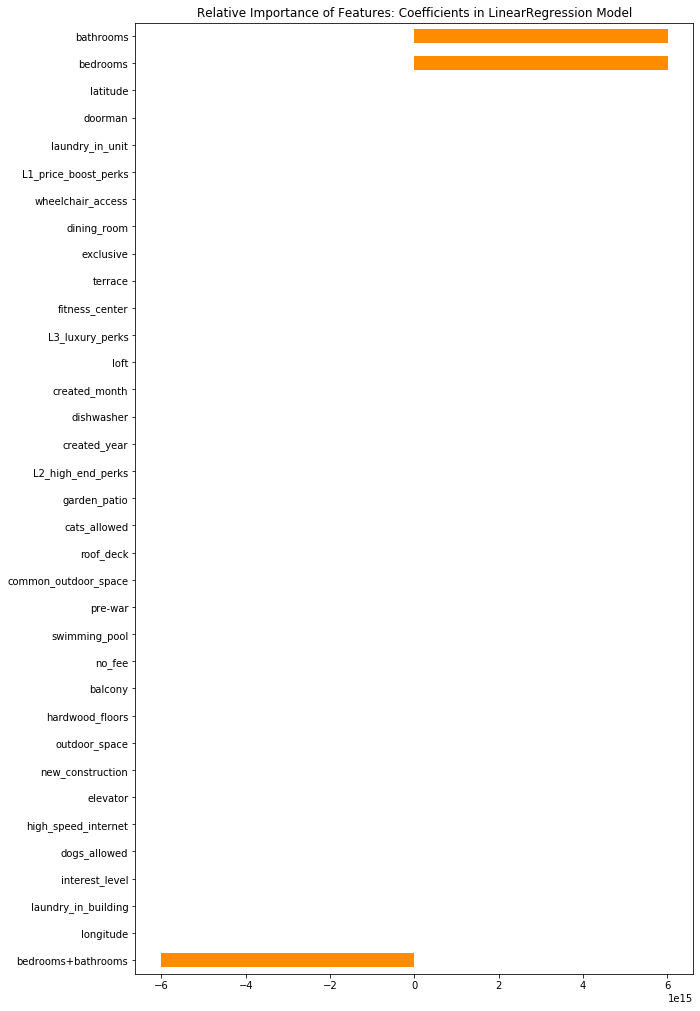

In [383]:
# Check linear regression coefficients to get a sense of feature importances:
fs1_linreg_coeffs = pd.Series(fs1_linreg.coef_, X_val.columns)

# Plot coefficients on chart:
n = len(X_val.columns)
plt.figure(figsize=(10, n/2))
fs1_linreg_coeffs.sort_values().plot.barh(color='darkorange')
plt.title('Relative Importance of Features: Coefficients in LinearRegression Model')
plt.show()

In [384]:
# [?? What?? -- how to work with coefficients in a linear regression model... these make no sense ??]
fs1_linreg_coeffs.loc['bathrooms']

6017692779066412.0

In [385]:
from sklearn.feature_selection import SelectFromModel

# Initiate SelectFromModel feature selector:
feature_selector_coeffs_raw = SelectFromModel(estimator=fs1_linreg, threshold='mean')

# Fit feature selector:
feature_selector_coeffs_raw.fit(X_train, y_train)

SelectFromModel(estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                           n_jobs=None, normalize=False),
                max_features=None, norm_order=1, prefit=False,
                threshold='mean')

In [386]:
# See which features are supported based on raw coefficients:
feature_names = X_train.columns
pd.DataFrame(feature_selector_coeffs_raw.get_support(), 
             index=feature_names, 
             columns=['include']).sort_values(by='include', ascending=False)

,include
bathrooms,True
bedrooms+bathrooms,True
bedrooms,True
L3_luxury_perks,False
L2_high_end_perks,False
L1_price_boost_perks,False
created_year,False
common_outdoor_space,False
wheelchair_access,False
dining_room,False


In [387]:
selected_features_coeffs_raw = feature_names[feature_selector_coeffs_raw.get_support()].tolist()
selected_features_coeffs_raw

['bathrooms', 'bedrooms', 'bedrooms+bathrooms']

Coeffs w/ Normalized Feature Matrices:

In [388]:
# Cross-check with normalized features going into linear regression model:

# Run linear regression model using all features, so we can then check which 
# are most important for our predictions:
# Multiple Linear Regression Model for the above NYC apartment rent data:

# (1) Import model class:
from sklearn.linear_model import LinearRegression

# (2) Initiate model:
fs1_linreg_normalized = LinearRegression(normalize=True)

# (3) Define features matrix and target vector:
# Already defined above.

# (4) Fit the model to our training data:
fs1_linreg_normalized.fit(X_train, y_train)

# Performance on training data:
print('Model Performance: LinearRegression w/ Normalized Inputs\n')

y_true_train = y_train
y_pred_train = fs1_linreg_normalized.predict(X_train)

print('On Training Set:')
print(f'Train MAE: {mean_absolute_error(y_true_train, y_pred_train):.1f}')
mse_train = mean_squared_error(y_true_train, y_pred_train)
print(f'Train MSE: {mse_train:.1f}')
print(f'Train RMSE: {sqrt(mse_train):.1f}')
print(f'Train R^2 score: {r2_score(y_true_train, y_pred_train):.2f}\n')

# Performance on validation set:
y_true_val = y_val
y_pred_val = fs1_linreg_normalized.predict(X_val)

print('On Validation Set:')
print(f'Train MAE: {mean_absolute_error(y_true_val, y_pred_val):.1f}')
mse_val = mean_squared_error(y_true_val, y_pred_val)
print(f'Train MSE: {mse_val:.1f}')
print(f'Train RMSE: {sqrt(mse_val):.1f}')
print(f'Train R^2 score: {r2_score(y_true_val, y_pred_val):.2f}\n')

Model Performance: LinearRegression w/ Normalized Inputs

On Training Set:
Train MAE: 738.2
Train MSE: 1674559.8
Train RMSE: 1294.0
Train R^2 score: 0.61

On Validation Set:
Train MAE: 753.4
Train MSE: 1716393.3
Train RMSE: 1310.1
Train R^2 score: 0.62



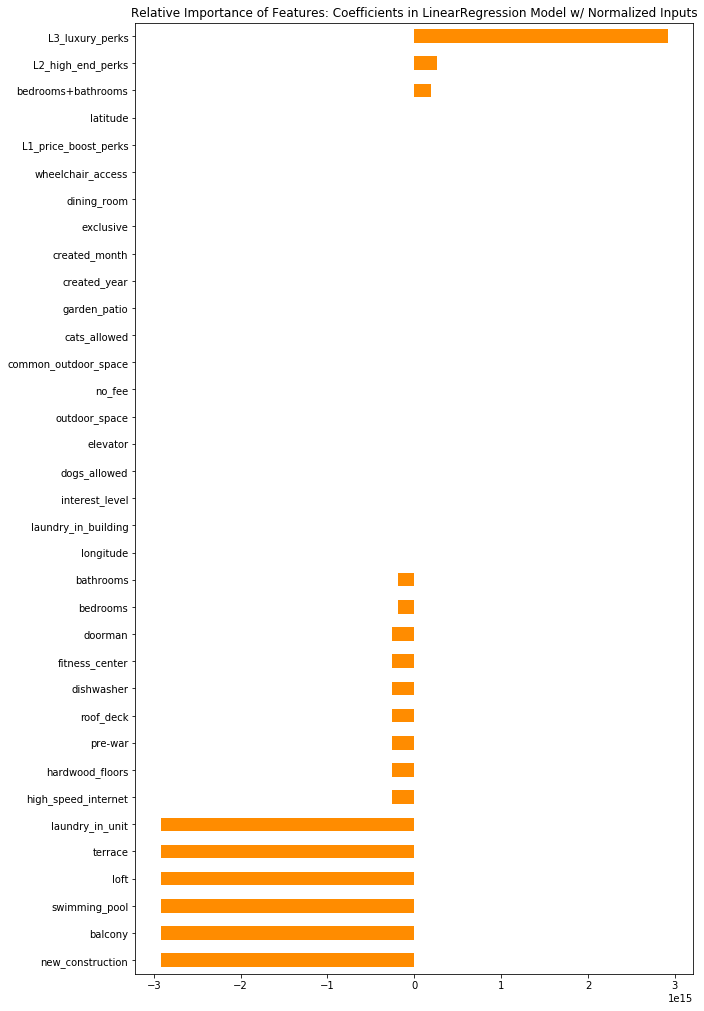

In [389]:
# Check linear regression coefficients to get a sense of feature importances:
fs1_linreg_normalized_coeffs = pd.Series(fs1_linreg_normalized.coef_, X_val.columns)

# Plot coefficients on chart:
n = len(X_val.columns)
plt.figure(figsize=(10, n/2))
fs1_linreg_normalized_coeffs.sort_values().plot.barh(color='darkorange')
plt.title('Relative Importance of Features: Coefficients in LinearRegression Model w/ Normalized Inputs')
plt.show()

In [390]:
from sklearn.feature_selection import SelectFromModel

# Initiate SelectFromModel feature selector:
feature_selector_coeffs_normalized = SelectFromModel(estimator=fs1_linreg_normalized, threshold='mean')

# Fit feature selector:
feature_selector_coeffs_normalized.fit(X_train, y_train)

SelectFromModel(estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                           n_jobs=None, normalize=True),
                max_features=None, norm_order=1, prefit=False,
                threshold='mean')

In [391]:
# See which features are supported based on raw coefficients:
feature_names = X_train.columns
pd.DataFrame(feature_selector_coeffs_normalized.get_support(), 
             index=feature_names, 
             columns=['include']).sort_values(by='include', ascending=False)

,include
loft,True
balcony,True
L3_luxury_perks,True
laundry_in_unit,True
swimming_pool,True
new_construction,True
terrace,True
bathrooms,False
exclusive,False
garden_patio,False


In [392]:
selected_features_coeffs_normalized = feature_names[feature_selector_coeffs_normalized.get_support()].tolist()
selected_features_coeffs_normalized

['laundry_in_unit',
 'balcony',
 'swimming_pool',
 'new_construction',
 'terrace',
 'loft',
 'L3_luxury_perks']

Coeffs w/ Standardized Feature Matrices:

In [393]:
# Cross-check with standardized feature values fed into linear regression model:

# (1) Import model class:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# (2) Initiate model:
fs1_linreg_standardized = LinearRegression()

# (3a) Define features matrix and target vector:
# Already defined above.

# (3b) Standardize our data, so we can better interpret the coefficients 
# w.r.t. what they mean about various features' importances:
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)

# (4) Fit the model to our training data:
fs1_linreg_standardized.fit(X_train_standardized, y_train)

# Performance on training data:
print('Model Performance: LinearRegression w/ Standardized Inputs\n')

y_true_train = y_train
y_pred_train = fs1_linreg_standardized.predict(X_train_standardized)

print('On Training Set:')
print(f'Train MAE: {mean_absolute_error(y_true_train, y_pred_train):.1f}')
mse_train = mean_squared_error(y_true_train, y_pred_train)
print(f'Train MSE: {mse_train:.1f}')
print(f'Train RMSE: {sqrt(mse_train):.1f}')
print(f'Train R^2 score: {r2_score(y_true_train, y_pred_train):.2f}\n')

# Performance on validation set:
y_true_val = y_val
y_pred_val = fs1_linreg_standardized.predict(X_val_standardized)

print('On Validation Set:')
print(f'Train MAE: {mean_absolute_error(y_true_val, y_pred_val):.1f}')
mse_val = mean_squared_error(y_true_val, y_pred_val)
print(f'Train MSE: {mse_val:.1f}')
print(f'Train RMSE: {sqrt(mse_val):.1f}')
print(f'Train R^2 score: {r2_score(y_true_val, y_pred_val):.2f}\n')

Model Performance: LinearRegression w/ Standardized Inputs

On Training Set:
Train MAE: 738.0
Train MSE: 1674551.5
Train RMSE: 1294.0
Train R^2 score: 0.61

On Validation Set:
Train MAE: 753.2
Train MSE: 1716556.5
Train RMSE: 1310.2
Train R^2 score: 0.62



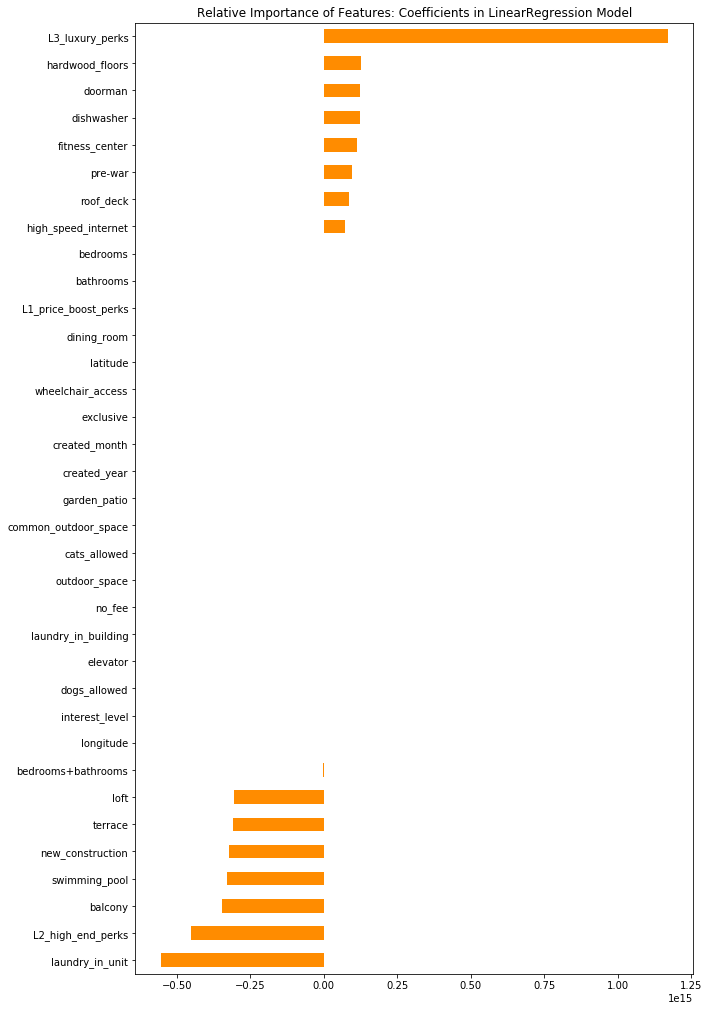

In [394]:
# Check linear regression coefficients to get a sense of feature importances:
fs1_linreg_standardized_coeffs = pd.Series(fs1_linreg_standardized.coef_, X_val.columns)

# Plot coefficients on chart:
n = len(X_val.columns)
plt.figure(figsize=(10, n/2))
fs1_linreg_standardized_coeffs.sort_values().plot.barh(color='darkorange')
plt.title('Relative Importance of Features: Coefficients in LinearRegression Model')
plt.show()

In [395]:
from sklearn.feature_selection import SelectFromModel

# Initiate SelectFromModel feature selector:
feature_selector_coeffs_standardized = SelectFromModel(estimator=fs1_linreg_standardized, threshold='median')

# Fit feature selector:
feature_selector_coeffs_standardized.fit(X_train, y_train)

SelectFromModel(estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                           n_jobs=None, normalize=False),
                max_features=None, norm_order=1, prefit=False,
                threshold='median')

In [396]:
# See which features are supported based on raw coefficients:
feature_names = X_train.columns
pd.DataFrame(feature_selector_coeffs_standardized.get_support(), 
             index=feature_names, 
             columns=['include']).sort_values(by='include', ascending=False)

,include
bathrooms,True
laundry_in_building,True
L1_price_boost_perks,True
bedrooms+bathrooms,True
wheelchair_access,True
exclusive,True
new_construction,True
high_speed_internet,True
dining_room,True
bedrooms,True


In [397]:
selected_features_coeffs_standardized = feature_names[feature_selector_coeffs_standardized.get_support()].tolist()
selected_features_coeffs_standardized

['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'interest_level',
 'elevator',
 'dogs_allowed',
 'doorman',
 'laundry_in_building',
 'laundry_in_unit',
 'outdoor_space',
 'dining_room',
 'high_speed_internet',
 'new_construction',
 'exclusive',
 'wheelchair_access',
 'bedrooms+bathrooms',
 'L1_price_boost_perks']

### Method 2: Recursive Feature Elimination:

In [398]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Initiate feature selector:
feature_selector_rfe = RFECV(estimator=fs1_linreg, step=1, cv=StratifiedKFold(n_splits=5, random_state=42), scoring="neg_mean_absolute_error")  # Alternative scoring options:  ‘neg_mean_squared_log_error’, ‘neg_root_mean_squared_error’, ‘neg_mean_squared_error’

# Fit feature selector:
feature_selector_rfe.fit(X_train, y_train)

# Performance on training data:
print('Model Performance: LinearRegression with RFECV for Feature Selection:\n')

y_true_train = y_train
y_pred_train = feature_selector_rfe.predict(X_train)

print('On Training Set:')
print(f'Train MAE: {mean_absolute_error(y_true_train, y_pred_train):.1f}')
mse_train = mean_squared_error(y_true_train, y_pred_train)
print(f'Train MSE: {mse_train:.1f}')
print(f'Train RMSE: {sqrt(mse_train):.1f}')
print(f'Train R^2 score: {r2_score(y_true_train, y_pred_train):.2f}\n')

# Performance on validation set:
y_true_val = y_val
y_pred_val = feature_selector_rfe.predict(X_val)

print('On Validation Set:')
print(f'Train MAE: {mean_absolute_error(y_true_val, y_pred_val):.1f}')
mse_val = mean_squared_error(y_true_val, y_pred_val)
print(f'Train MSE: {mse_val:.1f}')
print(f'Train RMSE: {sqrt(mse_val):.1f}')
print(f'Train R^2 score: {r2_score(y_true_val, y_pred_val):.2f}\n')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Model Performance: LinearRegression with RFECV for Feature Selection:

On Training Set:
Train MAE: 739.3
Train MSE: 1674986.9
Train RMSE: 1294.2
Train R^2 score: 0.61

On Validation Set:
Train MAE: 754.7
Train MSE: 1714820.6
Train RMSE: 1309.5
Train R^2 score: 0.62



Optimal number of features : 29
Capture bulk of accuracy with: 18


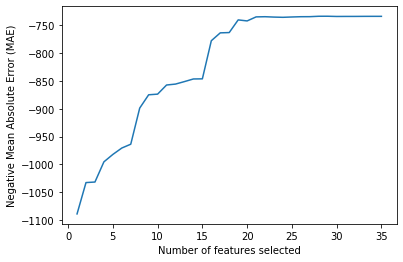

In [399]:
print("Optimal number of features : %d" % feature_selector_rfe.n_features_)
num_features_baseline = next(x for x, value in enumerate(feature_selector_rfe.grid_scores_) if value > -750)
print(f'Capture bulk of accuracy with: {num_features_baseline}')

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Negative Mean Absolute Error (MAE)")
plt.plot(range(1, len(feature_selector_rfe.grid_scores_) + 1), 
         feature_selector_rfe.grid_scores_)
plt.show()

In [400]:
ranks_rfecv = pd.DataFrame(data=feature_selector_rfe.ranking_, index=feature_names, columns=['ranking'])
ranks_rfecv['include'] = feature_selector_rfe.support_
ranks_rfecv['MAE_score'] = feature_selector_rfe.grid_scores_
ranks_rfecv.sort_values(by='include', ascending=False)

,ranking,include,MAE_score
bathrooms,1,True,-1089.025401
roof_deck,1,True,-763.661558
L3_luxury_perks,1,True,-734.025815
L1_price_boost_perks,1,True,-734.139392
bedrooms+bathrooms,1,True,-734.210700
common_outdoor_space,1,True,-733.817337
wheelchair_access,1,True,-733.860267
loft,1,True,-734.655883
exclusive,1,True,-735.149919
terrace,1,True,-735.739139


In [401]:
ranks_rfecv.sort_values(by=['MAE_score'], ascending=True)

,ranking,include,MAE_score
bathrooms,1,True,-1089.025401
bedrooms,1,True,-1032.704357
latitude,1,True,-1031.731089
longitude,1,True,-995.474425
interest_level,1,True,-982.136139
elevator,1,True,-970.639159
cats_allowed,2,False,-963.761407
hardwood_floors,1,True,-898.865937
dogs_allowed,1,True,-874.945025
doorman,1,True,-873.793324


In [402]:
feature_names = X_train.columns
selected_features_rfe = feature_names[feature_selector_rfe.support_].tolist()
selected_features_rfe

['bathrooms',
 'bedrooms',
 'latitude',
 'longitude',
 'interest_level',
 'elevator',
 'hardwood_floors',
 'dogs_allowed',
 'doorman',
 'no_fee',
 'laundry_in_building',
 'fitness_center',
 'pre-war',
 'laundry_in_unit',
 'roof_deck',
 'outdoor_space',
 'dining_room',
 'high_speed_internet',
 'balcony',
 'swimming_pool',
 'new_construction',
 'terrace',
 'exclusive',
 'loft',
 'wheelchair_access',
 'common_outdoor_space',
 'bedrooms+bathrooms',
 'L1_price_boost_perks',
 'L3_luxury_perks']

In [403]:
# Check if RFECV recommended features also include those recommended by the 
# model coeffs above --> if so, we will use the RFECV recommended top features:
condition_1 = all(elem in selected_features_rfe for elem in selected_features_coeffs_raw)
condition_2 = all(elem in selected_features_rfe for elem in selected_features_coeffs_normalized)
condition_3 = all(elem in selected_features_rfe for elem in selected_features_coeffs_standardized)

(condition_1 & condition_2 & condition_3)

True

### Final Selected Features:

In [0]:
# --> OK, let's use the RFECV recommended features then:
features = selected_features_rfe

# **Final Model:**

In [405]:
# (1) Import model class:
from sklearn.linear_model import LinearRegression

# (2) Initiate model:
m_final = LinearRegression()

# (3) Define features matrix and target vector:

# Features and target:
target = 'price'
features = selected_features_rfe  # Same as above.

# The resulting new final matrices & vectors:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

# (4) Fit the model to our training data:
m_final.fit(X_train, y_train)

# Performance on training data:
print('Model Performance:\n')

y_true_train = y_train
y_pred_train = m_final.predict(X_train)

print('On Training Set:')
print(f'Train MAE: {mean_absolute_error(y_true_train, y_pred_train):.1f}')
mse_train = mean_squared_error(y_true_train, y_pred_train)
print(f'Train MSE: {mse_train:.1f}')
print(f'Train RMSE: {sqrt(mse_train):.1f}')
print(f'Train R^2 score: {r2_score(y_true_train, y_pred_train):.2f}\n')

# Performance on validation set:
y_true_val = y_val
y_pred_val = m_final.predict(X_val)

print('On Validation Set:')
print(f'Train MAE: {mean_absolute_error(y_true_val, y_pred_val):.1f}')
mse_val = mean_squared_error(y_true_val, y_pred_val)
print(f'Train MSE: {mse_val:.1f}')
print(f'Train RMSE: {sqrt(mse_val):.1f}')
print(f'Train R^2 score: {r2_score(y_true_val, y_pred_val):.2f}\n')

Model Performance:

On Training Set:
Train MAE: 739.3
Train MSE: 1674986.9
Train RMSE: 1294.2
Train R^2 score: 0.61

On Validation Set:
Train MAE: 754.7
Train MSE: 1714820.6
Train RMSE: 1309.5
Train R^2 score: 0.62



### Final Results: Performance on New Data (Our Holdout Test Set)

In [406]:
# Performance on new data: our test set:
print('Final Model Performance on Test (Holdout) Set:\n')

y_true_test = y_test
y_pred_test = m_final.predict(X_test)

print('On Validation Set:')
print(f'Train MAE: {mean_absolute_error(y_true_test, y_pred_test):.2f}')
mse_val = mean_squared_error(y_true_test, y_pred_test)
print(f'Train MSE: {mse_val:.2f}')
print(f'Train RMSE: {sqrt(mse_val):.2f}')
print(f'Train R^2 score: {r2_score(y_true_test, y_pred_test):.2f}\n')

Final Model Performance on Test (Holdout) Set:

On Validation Set:
Train MAE: 746.94
Train MSE: 1711052.54
Train RMSE: 1308.07
Train R^2 score: 0.62

